# Document analysis, 30 Jan 2018
## Import everthing that is needed

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from nltk.corpus import PlaintextCorpusReader
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import mpld3
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import pandas as pd
import _pickle as cPickle
from __future__ import print_function
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag
from scipy.cluster.hierarchy import ward, dendrogram
import string

## Creating a corpus from a specified Dir and populating title and paper list

In [2]:
# Creating a corpus from a specified Dir
corpus_root = "/Users/juandrevanheerden/Desktop/txt/files/"
wordlists = PlaintextCorpusReader(corpus_root,'.*txt')

corpus = wordlists.words()

paper = []
titles = []
for i in range (0,len(wordlists.fileids())):
    paper.append(wordlists.raw(wordlists.fileids()[i]))
    titles.append(wordlists.fileids()[i])
    

# Stopwords, stemming, and tokenizing

In [3]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')


# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens



#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in paper:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    
    
    
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

## Tf-idf and document similarity

In [4]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(paper)

print(tfidf_matrix.shape)
                              
terms = tfidf_vectorizer.get_feature_names()



dist = 1 - cosine_similarity(tfidf_matrix)

CPU times: user 9.66 s, sys: 131 ms, total: 9.79 s
Wall time: 10.9 s
(42, 1039)


## K-means clustering

In [19]:
#num_clusters = len(wordlists.fileids())
num_clusters = 5
print(len(wordlists.fileids()))

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

#joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()


academicpaper = { 'title': titles, 'content': paper, 'cluster': clusters, }

frame = pd.DataFrame(academicpaper, index = [clusters] , columns = ['content', 'title', 'cluster'])

frame['cluster'].value_counts()


#grouped = frame['title'].groupby(frame['cluster'])

#grouped.mean()

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()
print()    
print()    

42
CPU times: user 374 ms, sys: 3.5 ms, total: 377 ms
Wall time: 376 ms
Top terms per cluster:

Cluster 0 words: b'forensic', b'digital', b'digital', b'evident', b'investigated', b'digital',

Cluster 0 titles:   Network security  Session chair-  A conceptual model for digital forensic readiness.pdf.txt, A sample of digital forensic quality assurance in the South African Criminal Justice System.pdf.txt, Adding Digital Forensic Readiness to Electronic Communication using a Security Monitoring Tool.pdf.txt, Challenges to Digital Forensics- A Survey of Researchers & Practitioners Attitudes and Opinions.pdf.txt, Digital Forensic Readiness in the Cloud.pdf.txt, Guidelines for procedures of a harmonized digital forensic process in network forensics.pdf.txt, Implementation Guidelines for a Harmonised Digital Forensic Investigation Readiness Process Model.pdf.txt, Network Forensics in a Clean-slate Internet Architecture.pdf.txt, Selection and Ranking of Remote Hosts for Digital Forensic Investi

/Users/juandrevanheerden/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


## Multidimensional scaling

In [20]:
MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


## Visualizing document clusters

/Users/juandrevanheerden/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


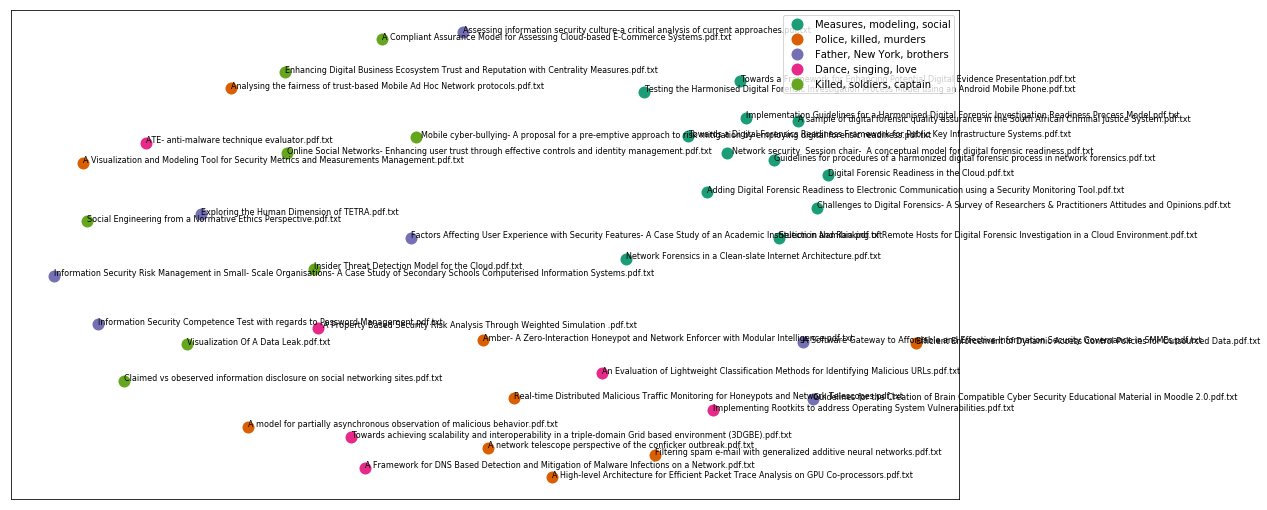

In [21]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Measures, modeling, social', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}



%matplotlib inline



#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)

In [22]:
plt.close()

In [23]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}
        
        
        
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

## Hierarchical document clustering

In [30]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=400) #save figure as ward_clusters

plt.close()

## Latent Dirichlet Allocation

In [25]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [26]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [27]:
#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in paper]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 3.58 s, sys: 18.1 ms, total: 3.6 s
Wall time: 3.61 s
CPU times: user 4.84 s, sys: 47.1 ms, total: 4.89 s
Wall time: 4.97 s
CPU times: user 353 ms, sys: 2.4 ms, total: 355 ms
Wall time: 354 ms


In [28]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]


%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)
print()
print()

lda.show_topics()
#topics = lda.print_topics(5, num_words=10)

CPU times: user 1min 32s, sys: 2.04 s, total: 1min 34s
Wall time: 1min 33s




[(0,
  '0.011*"manag" + 0.011*"control" + 0.011*"risk" + 0.009*"program" + 0.008*"studi" + 0.007*"organis" + 0.007*"educ" + 0.006*"password" + 0.006*"awar" + 0.006*"phase"'),
 (1,
  '0.011*"malici" + 0.010*"domain" + 0.010*"engin" + 0.009*"host" + 0.009*"detect" + 0.009*"malwar" + 0.009*"rootkit" + 0.008*"social" + 0.008*"product" + 0.008*"anti-malwar"'),
 (2,
  '0.014*"cultur" + 0.013*"measur" + 0.012*"assess" + 0.012*"metric" + 0.011*"assur" + 0.007*"visual" + 0.007*"organ" + 0.006*"cloud" + 0.006*"challeng" + 0.006*"tool"'),
 (3,
  '0.034*"digit" + 0.032*"forens" + 0.026*"evid" + 0.017*"investig" + 0.009*"incid" + 0.009*"potenti" + 0.008*"phase" + 0.007*"attack" + 0.006*"readi" + 0.006*"respond"'),
 (4,
  '0.014*"trust" + 0.014*"node" + 0.013*"key" + 0.010*"packet" + 0.009*"agent" + 0.008*"reput" + 0.008*"protocol" + 0.008*"messag" + 0.006*"social" + 0.005*"header"')]

In [29]:
# convert topics into list of top 20 words in each topics
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix, dtype=object)

topic_words = topics_matrix[:,1]

for i in topic_words:
    print([str(word) for word in i])
    print()

["('manag', 0.011361389)", "('control', 0.011138045)", "('risk', 0.011095944)", "('program', 0.008838292)", "('studi', 0.0079793595)", "('organis', 0.006973838)", "('educ', 0.006920101)", "('password', 0.006445458)", "('awar', 0.0059721116)", "('phase', 0.005752949)", "('social', 0.0055421847)", "('behaviour', 0.005323471)", "('servic', 0.0052039013)", "('threat', 0.005064833)", "('pp', 0.004974233)", "('learn', 0.0049590855)", "('interact', 0.0048512267)", "('individu', 0.0048216055)", "('protect', 0.0047350475)", "('experi', 0.004693299)"]

["('malici', 0.011038371)", "('domain', 0.010211011)", "('engin', 0.009846097)", "('host', 0.009441347)", "('detect', 0.009355503)", "('malwar', 0.0089283995)", "('rootkit', 0.0087054195)", "('social', 0.008439467)", "('product', 0.00803118)", "('anti-malwar', 0.00798089)", "('ethic', 0.007869532)", "('name', 0.0070516136)", "('trafﬁc', 0.006812866)", "('compon', 0.0066791065)", "('attack', 0.0066154697)", "('classiﬁ', 0.0060608448)", "('test', 0.